<a href="https://colab.research.google.com/github/lautitorraca/7506R-2C2023-GRUPO24/blob/main/TP2/7506R_TP2_GRUPO24_ENSAMBLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 𝔾𝕣𝕦𝕡𝕠 𝟚𝟜 (Merequetengue👍)

  ➢ Torraca Lautaro - 108813

  ➢ Negrotti Gianluca - 108184

  ➢ Marco Tosi - 107237

### > Imports

In [ ]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.linear_model import LogisticRegression



### > Lectura de los datasets

In [ ]:
url_train = '/content/train_limpio.csv'
url_test = '/content/test_limpio.csv'

df_train = pd.read_csv(url_train)
df_test = pd.read_csv(url_test)

train = df_train.copy()
test = df_test.copy()

### > Ensamble Voting

- Division y vecotirzacion de los textos

In [ ]:
print(train['sentimiento'].value_counts())

positivo    25000
negativo    25000
Name: sentimiento, dtype: int64


In [ ]:

# Separar los datos en características y objetivo
X = train['review_es_clean']
y = train['sentimiento'].apply(lambda x: 1 if x == 'positiva' else 0)

#Encodeado de los textos
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(train['sentimiento'])


# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify= train['sentimiento'],
                                                    shuffle=True)

# Vectorización de los textos
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)



- Creacion de los modelos y creacion del ensamble

In [ ]:
# Crear los modelos
rf = RandomForestClassifier(n_estimators=100, random_state=42)
nb = MultinomialNB()
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Ensamble Voting Classifier
voting_clf = VotingClassifier(estimators=[('rf', rf), ('nb', nb), ('xgb', xgb)], voting='soft')


- Entrenamiento y prediccion

In [ ]:
# Entrenar el modelo de ensamble
voting_clf.fit(X_train_tfidf, y_train)

# Predeccion
y_pred = voting_clf.predict(X_test_tfidf)

- Guardado del modelo con pickle

In [ ]:
# Guardar el modelo entrenado
with open('ensamble_voting.pkl', 'wb') as file:
    pickle.dump(voting_clf, file)

# Descargar el archivO
try:
    from google.colab import files
    files.download('ensamble_voting.pkl')
except ImportError:
    print("Error")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

- Muestra de metricas y matriz de confusion

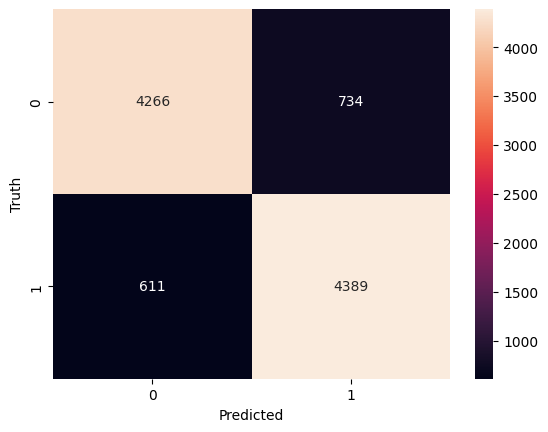

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [ ]:
def mostrar_metricas(y_test, y_pred):
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)

  print(f"Accuracy: {accuracy:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1 Score: {f1:.4f}")

In [ ]:
mostrar_metricas(y_test, y_pred)

Accuracy: 0.8655
Precision: 0.8567
Recall: 0.8778
F1 Score: 0.8671


- Prediccion con voting

In [ ]:

# Transformar las reviews del conjunto de prueba usando el vectorizador
X_test_tfidf = vectorizer.transform(test['review_es_clean'])

# Realizar predicciones con el ensamble de voting
prediccion_voting = voting_clf.predict(X_test_tfidf)

# Crear un DataFrame con los resultados
prediccion_voting = pd.DataFrame({'ID': test['ID'], 'sentimiento': prediccion_voting})

# Convertir las etiquetas numéricas a etiquetas de texto
prediccion_voting['sentimiento'] = prediccion_voting['sentimiento'].map({0: 'negativo', 1: 'positivo'})

# Guardar las predicciones en un archivo CSV
prediccion_voting.to_csv('predicciones_ensamble_voting.csv', index=False)

# Descargar el archivo de predicciones
try:
    from google.colab import files
    files.download('predicciones_ensamble_voting.csv')
except ImportError:
    print("La función de descarga solo funciona en entornos como Google Colab.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### > Ensamble Stacking

Para stacking utilizamos todo la anterior

In [ ]:
lr = LogisticRegression()
# Stacking Classifier
stacking_clf = StackingClassifier(estimators=[('rf', rf), ('nb', nb), ('xgb', xgb)], final_estimator=lr)

- Entrenamiento y prediccion

In [ ]:
# Entrenamiento del modelo
stacking_clf.fit(X_train_tfidf, y_train)

# Predeccion
y_pred_stacking = voting_clf.predict(X_test_tfidf)

- Guardado del modelo con pickle

In [ ]:


with open('stacking_classifier.pkl', 'wb') as file:
    pickle.dump(stacking_clf, file)

# Descargar el archivO
try:
    from google.colab import files
    files.download('stacking_classifier.pkl')
except ImportError:
    print("Error")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

- Prediccion con stacking

In [ ]:

# Transformar las reviews del conjunto de prueba usando el vectorizador TF-IDF
X_test_tfidf = vectorizer.transform(test['review_es_clean'])

# Realizar predicciones con el ensamble de stacking
prediccion_stacking = stacking_clf.predict(X_test_tfidf)

# Crear un DataFrame con los resultados
prediccion_stacking = pd.DataFrame({'ID': test['ID'], 'sentimiento': prediccion_stacking})

# Convertir las etiquetas numéricas a etiquetas de texto
prediccion_stacking['sentimiento'] = prediccion_stacking['sentimiento'].map({0: 'negativo', 1: 'positivo'})

# Guardar las predicciones en un archivo CSV
prediccion_stacking.to_csv('predicciones_ensamble_stacking.csv', index=False)

# Descargar el archivo de predicciones
try:
    from google.colab import files
    files.download('predicciones_ensamble_stacking.csv')
except ImportError:
    print("La función de descarga solo funciona en entornos como Google Colab.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>